# INTRODUCTION

This notebook aims at providing a first approach to manage the new code review database. The usual code review process is done through the mailing lists. This approach migrates that code review into a database schema closer to how Gerrit or another review system works.

The list of metrics for this notebook are the following ones:

Activity General Overview
-------------------------
* Evolution of patch series (1 or more patches)
* Evolution of patch series submitters
* Evolution of comments
* Evolution of people commenting the patch series
* Evolution of people reviewing patches (using the flag reviewed by)

Time analysis
-------------

A patch can be divided into several steps:

1---------2----------3---------4--------5---------A--------C

And each version can be divided into several steps:

1----a)review------b)review------c)review-----------d)review--------------2----------------------------------------------3
    
    

Where 1, 2, 3, .., are the several iterations, A the point where all of the patches were 'Acked-by' and C the commit action into master.
And a, b, c, d comments and reviews.


* Time to merge: time between 1 and C
* Time to commit: time between A and C
* Time to re-work a patch: time between 1_d and the new iteration. Time between the last comment and a new patch.
* Cycle time: time between each pair of iterations: 1&2, 2&3, etc.
* Time to first review: time between 1, 2, 3, etc and its first review.

Backlog analysis
----------------
* Review (of series/patch) completed: all of the patch series merged
* Review (of series/patch) active: patches that were recently reviewed, we'll take the last 7 days as a potential timeframe.
* Review (of series/patch) stalled: patches older than 1 year
* Review (of series/patch) ongoing: patches younger than 1 year. This would include the active reviews.

Patch series complexity analysis
--------------------------------
* Number of versions per patch serie
* From patches merged: check number of 'touched' files plus added and removed lines
* Comments received per patch
* Number of patches per patch serie

Patch series community
----------------------
* Top people sending patches
* Top people reviewing patches
* For all of those, basic analysis with organization info based on email domain

Analysis
--------


# 0) LIBRARIES NEEDED FOR THIS NOTEBOOK

In [1]:
%pylab inline
# Enabling libraries to manage data and plot
import pandas as pd
import numpy as np
from pandas import Series, DataFrame, Panel

Populating the interactive namespace from numpy and matplotlib


# 0) DATABASE CONNECTION

In [2]:
# Working with the xen-database with code review info
import MySQLdb


def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "Xen_Revised Code review"

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db)
      return db, db.cursor()
   except:
      logging.error("Database connection error")
      raise
        


def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    

db, cursor = connect()

In [3]:
def draw_distribution(data_df, key_field, hist, boxplot, boxplot_log=True):
    # This function draws as histogram and boxplot the distribution 
    # of the specified charts.
    # data: raw data coming from database
    # columns_list: list of columns represented in 'data'
    # key_field: key field to be represented in the histogram and boxplot
    # hist: contains the xlabel, ylabel and title fields
    # boxplot: contains the ylabel and title fields
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))

    hist_chart = data_df[key_field].plot(kind="hist", ax=axs[0])
    boxplot_chart = data_df[key_field].plot(kind="box", ax=axs[1], logy=boxplot_log)

    #chart labels
    hist_chart.set_xlabel(hist["xlabel"])
    hist_chart.set_ylabel(hist["ylabel"])
    hist_chart.set_title(hist["title"])

    boxplot_chart.set_ylabel(boxplot["ylabel"])
    boxplot_chart.set_title(boxplot["title"])

# 1) ACTIVITY GENERAL OVERVIEW

Metrics to retrieve:
* Evolution of patch series (1 or more patches)
* Evolution of patch series submitters
* Evolution of comments
* Evolution of people commenting the patch series
* Evolution of people reviewing patches (using the flag reviewed by)

## Evolution of Patch Series

Xen community uses the term patch or patch serie when sending pieces of code to the mailing list. In order to simplify this process, a patch serie is now conformed of one or more patches.

In [4]:
query = """ SELECT year,
                   month,
                   count(distinct(ps)) as patch_series
            FROM 
                 (SELECT ps_version_id as ps,
                         year(min(date_utc)) as year,
                         month(min(date_utc)) as month
                  FROM patches
                  GROUP BY ps_version_id
                  ORDER BY min(date_utc)) t
            GROUP BY year, month
        """
data = execute_query(cursor, query)

In [5]:
np_data = np.array(data)
np_data_filtered = np_data[24:-6] # This remove 2001 and 2016 data
#Migrating to use Series in pandas (nicer view and easier to manage series)
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-31
#Checking size of both arrays: dates.shape and np_data_filtered.shape
patchserieTS = Series(np_data_filtered[:,2], index=dates)

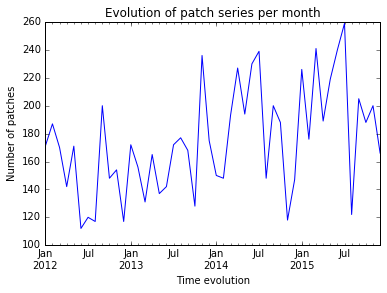

In [6]:
patchserieschart = patchserieTS.plot()
patchserieschart.set_xlabel("Time evolution")
patchserieschart.set_ylabel("Number of patches")
patchserieschart.set_title("Evolution of patch series per month")

## Evolution of Patch Series Submitters

In [7]:
query = """ SELECT year,
                   month,
                   count(distinct(submitter)) as submitters
            FROM 
                 (SELECT submitter_id as submitter,
                         year(min(date_utc)) as year,
                         month(min(date_utc)) as month
                  FROM patches
                  GROUP BY ps_version_id
                  ORDER BY min(date_utc)) t
            GROUP BY year, month
        """
data_submitters = execute_query(cursor, query)

In [8]:
np_data = np.array(data_submitters)
np_data_filtered = np_data[24:-6] # This remove 2001 and 2016 data
patchserie_submittersTS = Series(np_data_filtered[:,2], index=dates)

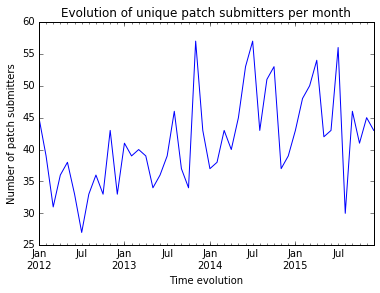

In [9]:
patchserie_submitters_chart = patchserie_submittersTS.plot()
patchserie_submitters_chart.set_xlabel("Time evolution")
patchserie_submitters_chart.set_ylabel("Number of patch submitters")
patchserie_submitters_chart.set_title("Evolution of unique patch submitters per month")

## Evolution of comments

In [10]:
# Let's calculate evolution of comments in general when they were sent
# We should ignore 1970 emails with wrong sent date
query = """ SELECT year(date_utc) as year,
                   month(date_utc) as month,
                   count(distinct(comments.id)) as comments
            FROM comments
            WHERE year(date_utc) > 2004
            GROUP BY year(date_utc),
                     month(date_utc)
        """
comments = execute_query(cursor, query)

In [11]:
np_data = np.array(comments)
np_data_filtered = np_data[24:-6]
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
commentsTS = Series(np_data_filtered[:,2], index=dates)


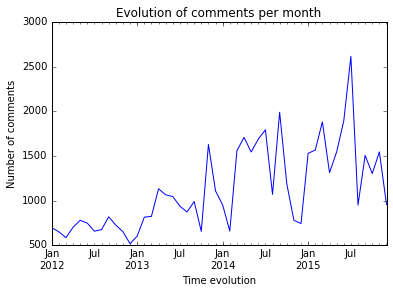

In [12]:
comments_chart = commentsTS.plot()
#patchserieschart = patchserieTS.plot()
comments_chart.set_xlabel("Time evolution")
comments_chart.set_ylabel("Number of comments")
comments_chart.set_title("Evolution of comments per month")

## Evolution of people commenting the patch series

In [13]:
query = """ SELECT psv.ps_id as patch_serie,
                   MIN(psv.date_utc) as patch_serie_sent_date,
                   COUNT(DISTINCT(c.submitter_id)) as commenters
            FROM patch_series_version psv,
                 patches p,
                 comments c 
            WHERE psv.id = p.ps_version_id AND 
                  p.id=c.patch_id 
            GROUP BY psv.ps_id """
peoplecomments_ps = execute_query(cursor, query)

In [14]:
peoplecomments_list = list(peoplecomments_ps)
peoplecomments_df = DataFrame(peoplecomments_list, columns=["patch_serie", "partch_serie_sent_date", "commenters"])

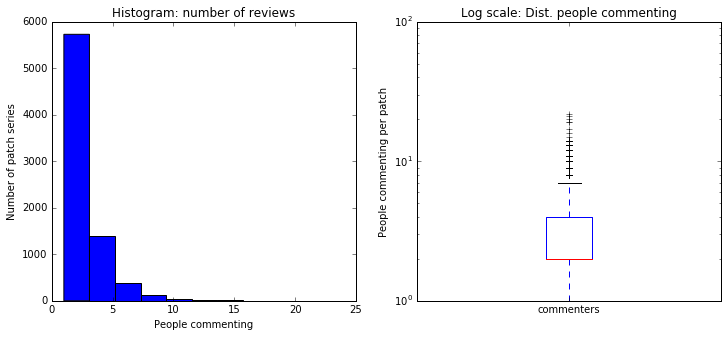

In [15]:
hist = {"xlabel":"People commenting", "ylabel":"Number of patch series", "title":"Histogram: number of reviews"}
boxplot = {"ylabel":"People commenting per patch", "title":"Log scale: Dist. people commenting"}
draw_distribution(peoplecomments_df, "commenters", hist, boxplot)

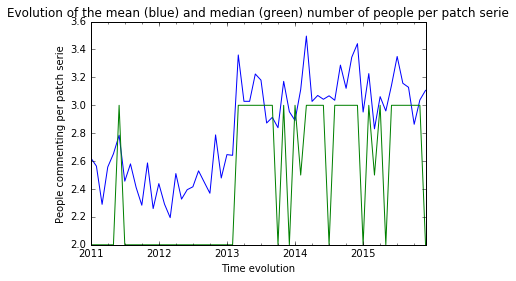

In [16]:
mean_peoplecomments = peoplecomments_df.set_index("partch_serie_sent_date").resample('M', how={"commenters":np.mean})
median_peoplecomments = peoplecomments_df.set_index("partch_serie_sent_date").resample('M', how={"commenters":np.median})
dates = pd.date_range('2011-01-01', '2016-01-01', freq='M') # data starting in 2010-10 and ending in 2015-08
peoplecommentsTS = Series(mean_peoplecomments["commenters"], index=dates)
peoplecomments_medianTS = Series(median_peoplecomments["commenters"], index=dates)

peoplecommentsTS_chart = peoplecommentsTS.plot()
peoplecomments_medianTS.plot()
peoplecommentsTS_chart.set_xlabel("Time evolution")
peoplecommentsTS_chart.set_ylabel("People commenting per patch serie")
peoplecommentsTS_chart.set_title("Evolution of the mean (blue) and median (green) number of people per patch serie")

# 2) TIME ANALYSIS

Metrics to retrieve:
* Time to merge: time between 1 and C
* Time to commit: time between A and C
* Time to re-work a patch: time between 1_d and the new iteration. Time between the last comment and a new patch.
* Cycle time: time between each pair of iterations: 1&2, 2&3, etc.
* Time to first review: time between 1, 2, 3, etc and its first review.
* Time to ack

## Time to merge

Time to merge needs to be calculated as the time when a patch was initially sent till this is merge into code. As each patch is associated to a commit, this is obtained as the first date when the patch was sent till the last commit for that patch serie is merged into code.

In [17]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MIN(psv.date_utc), MAX(c.committer_date_utc)) as time2merge,
                   MIN(psv.date_utc) as first_patch_date,
                   MAX(c.committer_date_utc) as merge_time
            FROM patch_series_version psv,
                 patches p,
                 commits c
            WHERE psv.id=p.ps_version_id AND 
                  p.commit_id = c.id 
            GROUP BY psv.ps_id
            HAVING time2merge >=0 """
time2merge = execute_query(cursor, query)

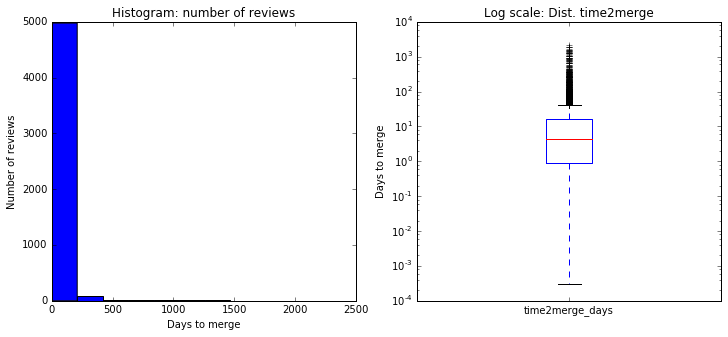

In [18]:
time2merge_list = list(time2merge)
time2merge_df = DataFrame(time2merge_list, columns=["patch_serie", "time2merge", "first_patch_date", "merge_time"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2merge_df["time2merge_days"] = (time2merge_df["time2merge"]/3600)/24


hist_chart = time2merge_df["time2merge_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2merge_df["time2merge_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to merge")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to merge")
boxplot_chart.set_title("Log scale: Dist. time2merge")

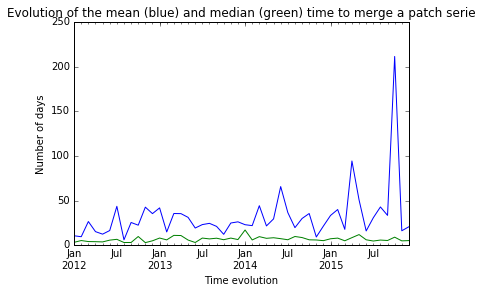

In [19]:
mean_time2merge = time2merge_df.set_index("merge_time").resample('M', how={"time2merge_days":np.mean})
median_time2merge = time2merge_df.set_index("merge_time").resample('M', how={"time2merge_days":np.median})
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
time2mergeTS = Series(mean_time2merge["time2merge_days"], index=dates)
time2merge_medianTS = Series(median_time2merge["time2merge_days"], index=dates)

time2mergeTS_chart = time2mergeTS.plot()
time2merge_medianTS.plot()
time2mergeTS_chart.set_xlabel("Time evolution")
time2mergeTS_chart.set_ylabel("Number of days")
time2mergeTS_chart.set_title("Evolution of the mean (blue) and median (green) time to merge a patch serie")

## Time to commit

In [20]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MAX(c.date_utc), MAX(commits.committer_date_utc)) as time2commit,
                   MAX(c.date_utc) as last_comment_date, 
                   MAX(commits.committer_date_utc) as commit_time 
            FROM patch_series_version psv, 
                 patches p, 
                 comments c, 
                 commits 
            WHERE psv.id = p.ps_version_id AND 
                  p.commit_id = commits.id AND 
                  p.id=c.patch_id 
            GROUP BY psv.ps_id
            HAVING time2commit >= 0 and time2commit < 2000*3600*24"""
time2commit = execute_query(cursor, query)

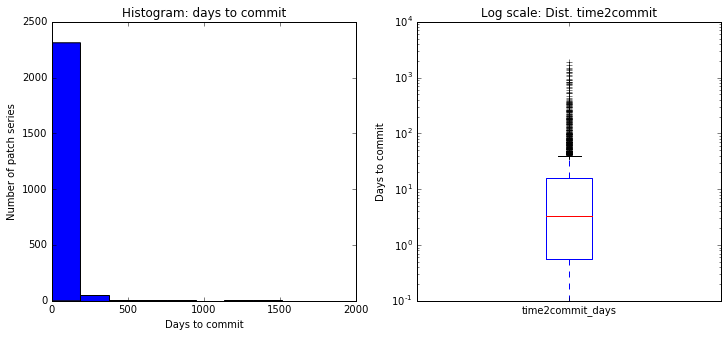

In [21]:
time2commit_list = list(time2commit)
time2commit_df = DataFrame(time2commit_list, columns=["patch_serie", "time2commit", "last_comment_date", "commit_time"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2commit_df["time2commit_days"] = (time2commit_df["time2commit"]/3600)/24


hist_chart = time2commit_df["time2commit_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2commit_df["time2commit_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to commit")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to commit")

boxplot_chart.set_ylabel("Days to commit")
boxplot_chart.set_title("Log scale: Dist. time2commit")

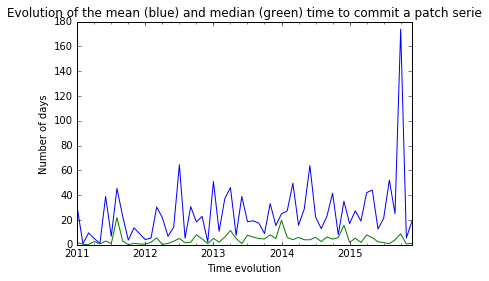

In [22]:
mean_time2commit = time2commit_df.set_index("commit_time").resample('M', how={"time2commit_days":np.mean})
median_time2commit = time2commit_df.set_index("commit_time").resample('M', how={"time2commit_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
time2commitTS = Series(mean_time2commit["time2commit_days"], index=dates)
time2commit_medianTS = Series(median_time2commit["time2commit_days"], index=dates)

time2commitTS_chart = time2commitTS.plot()
time2commit_medianTS.plot()
time2commitTS_chart.set_xlabel("Time evolution")
time2commitTS_chart.set_ylabel("Number of days")
time2commitTS_chart.set_title("Evolution of the mean (blue) and median (green) time to commit a patch serie")

## Time to re-work a patch

In [23]:
query = """ SELECT psv.ps_id as patch_serie,
                   psv.version as version,
                   psv.date_utc as rework_time, 
                   t.last_activity as last_version_activity, 
                   timestampdiff(SECOND, psv.date_utc, t.last_activity) as time2rework 
            FROM patch_series_version psv, 
                 (SELECT psv.ps_id, 
                         psv.version, 
                         greatest(max(c.date_utc), max(p.date_utc)) as last_activity 
                  FROM patch_series_version psv, 
                       patches p, 
                       comments c 
                  WHERE psv.id = p.ps_version_id AND 
                        c.patch_id=p.id 
                  GROUP BY psv.ps_id, psv.version) t 
            WHERE psv.ps_id = t.ps_id AND 
                  psv.version = t.version -1
            HAVING time2rework >= 0 and time2rework < 1000*3600*24"""
time2rework = execute_query(cursor, query)

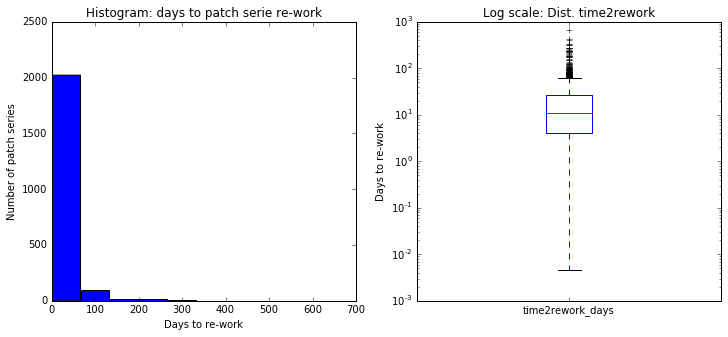

In [24]:
time2rework_list = list(time2rework)
time2rework_df = DataFrame(time2rework_list, columns=["patch_serie", "version", "rework_time", "last_version_activity", "time2rework"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2rework_df["time2rework_days"] = (time2rework_df["time2rework"]/3600)/24


hist_chart = time2rework_df["time2rework_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2rework_df["time2rework_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to re-work")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to patch serie re-work")

boxplot_chart.set_ylabel("Days to re-work")
boxplot_chart.set_title("Log scale: Dist. time2rework")

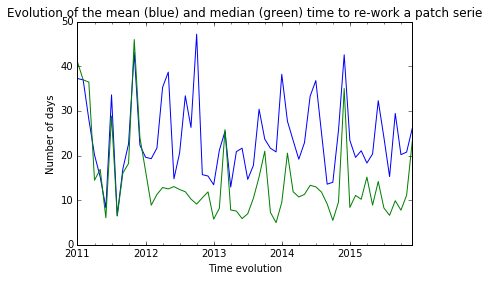

In [25]:
mean_time2rework = time2rework_df.set_index("rework_time").resample('M', how={"time2rework_days":np.mean})
median_time2rework = time2rework_df.set_index("rework_time").resample('M', how={"time2rework_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
time2reworkTS = Series(mean_time2rework["time2rework_days"], index=dates)
time2rework_medianTS = Series(median_time2rework["time2rework_days"], index=dates)

time2reworkTS_chart = time2reworkTS.plot()
time2rework_medianTS.plot()
time2reworkTS_chart.set_xlabel("Time evolution")
time2reworkTS_chart.set_ylabel("Number of days")
time2reworkTS_chart.set_title("Evolution of the mean (blue) and median (green) time to re-work a patch serie")

## Cycle time

In [26]:
query = """ SELECT p1.ps_id as patch_serie,
                   p1.version as version,
                   p1.date_utc as cycle1,
                   p2.date_utc as cycle2,
                   timestampdiff(SECOND, p1.date_utc, p2.date_utc) as time2newcycle
            FROM patch_series_version p1,
                 patch_series_version p2
            WHERE p1.ps_id = p2.ps_id AND 
                  p1.version = p2.version -1 
            HAVING time2newcycle >= 0 and time2newcycle<1000*3600*24
            ORDER BY p1.ps_id  """
time2newcycle = execute_query(cursor, query)

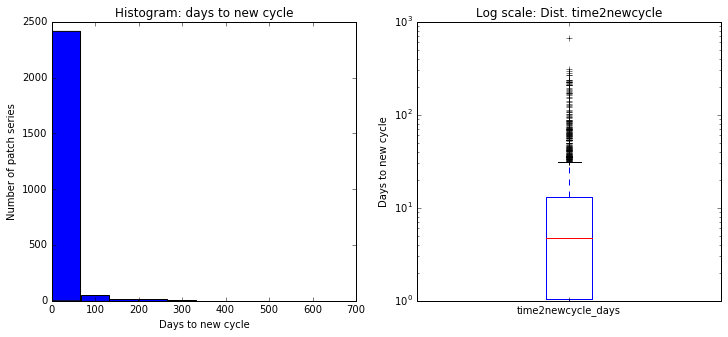

In [27]:
time2newcycle_list = list(time2newcycle)
time2newcycle_df = DataFrame(time2newcycle_list, columns=["patch_serie", "version", "cycle1", "cycle2", "time2newcycle"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2newcycle_df["time2newcycle_days"] = (time2newcycle_df["time2newcycle"]/3600)/24


hist_chart = time2newcycle_df["time2newcycle_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2newcycle_df["time2newcycle_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to new cycle")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to new cycle")

boxplot_chart.set_ylabel("Days to new cycle")
boxplot_chart.set_title("Log scale: Dist. time2newcycle")

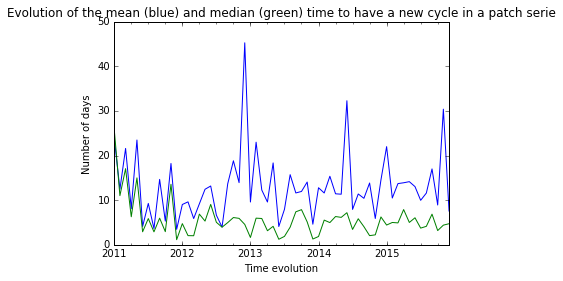

In [28]:
mean_time2newcycle = time2newcycle_df.set_index("cycle2").resample('M', how={"time2newcycle_days":np.mean})
median_time2newcycle = time2newcycle_df.set_index("cycle2").resample('M', how={"time2newcycle_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2newcycleTS = Series(mean_time2newcycle["time2newcycle_days"], index=dates)
time2newcycle_medianTS = Series(median_time2newcycle["time2newcycle_days"], index=dates)

time2newcycleTS_chart = time2newcycleTS.plot()
time2newcycle_medianTS.plot()
time2newcycleTS_chart.set_xlabel("Time evolution")
time2newcycleTS_chart.set_ylabel("Number of days")
time2newcycleTS_chart.set_title("Evolution of the mean (blue) and median (green) time to have a new cycle in a patch serie")

## Time to first review

Either this is a patch or a patch serie, this analysis is focused at the level of patch. This ignores all of the patches that are not reviewed.
At the level of 'flags', this counts the time between a patch is sent till a 'Reviewed-by' flag appears.

Some issues found:
* When a patch sent to the mailing list already contains review information. Example at http://lists.xen.org/archives/html/xen-devel/2007-06/msg00320.html
* When the same patch is sent again with such Reviewed-by info. Example in the same thread than above, but in a different email: http://lists.xen.org/archives/html/xen-devel/2007-06/msg00333.html

Assumption:
* Let's ignore first time reviews, so let's analyze only those times whose time to review is greater than 0 and when a patch has more than 1 review, selecting the minimum time among them. In this way, we'll avoid to have more than one repeated review.


In [29]:
query = """ SELECT p.subject as subject,
                   p.date_utc as sent_date,
                   f.flag as flag,
                   f.date_utc as reviewed_date,
                   TIMESTAMPDIFF(SECOND, p.date_utc, min(f.date_utc)) as time2review
            FROM patches p,
                 flags f
            WHERE p.id = f.patch_id  and
                  f.flag='Reviewed-by' 
            GROUP BY p.subject 
            HAVING TIMESTAMPDIFF(SECOND, p.date_utc, min(f.date_utc)) > 0 and TIMESTAMPDIFF(SECOND, p.date_utc, min(f.date_utc))
        """
time2review = execute_query(cursor, query)

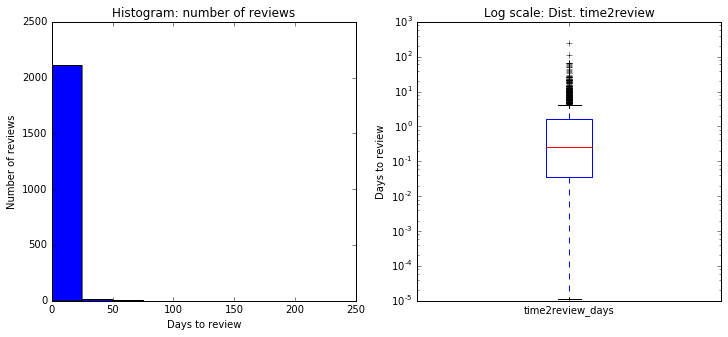

In [30]:
time2review_list = list(time2review)
time2review_df = DataFrame(time2review_list, columns=["subject", "date", "flag", "review_time", "time2review"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2review_df["time2review_days"] = (time2review_df["time2review"]/3600)/24


hist_chart = time2review_df["time2review_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2review_df["time2review_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to review")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to review")
boxplot_chart.set_title("Log scale: Dist. time2review")

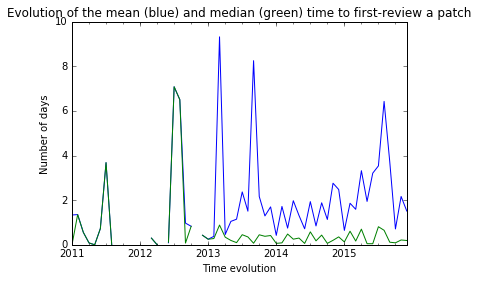

In [31]:
mean_time2review = time2review_df.set_index("review_time").resample('M', how={"time2review_days":np.mean})
median_time2review = time2review_df.set_index("review_time").resample('M', how={"time2review_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
time2reviewTS = Series(mean_time2review["time2review_days"], index=dates)
time2review_medianTS = Series(median_time2review["time2review_days"], index=dates)

time2reviewTS_chart = time2reviewTS.plot()
time2review_medianTS.plot()
time2reviewTS_chart.set_xlabel("Time evolution")
time2reviewTS_chart.set_ylabel("Number of days")
time2reviewTS_chart.set_title("Evolution of the mean (blue) and median (green) time to first-review a patch")

## Time to ack

In [32]:
query = """ SELECT t1.ps_id as patch_serie,
                   t1.first_patch_date,
                   f.flag as flag,
                   f.date_utc as acked_date,
                   TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date_utc)) as time2ack
            FROM patches p,
                 flags f,
                 (select psv.ps_id,
                         p.id as patch_id, 
                         min(psv.date_utc) as first_patch_date
                  from patch_series_version psv,
                       patches p
                  where p.ps_version_id=psv.id
                  group by psv.ps_id) t1
            WHERE p.id = f.patch_id  and
                  f.flag='Acked-by' and
                  p.id = t1.patch_id
            GROUP BY t1.ps_id 
            HAVING TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date_utc)) > 0 and TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date_utc))
        """
time2ack = execute_query(cursor, query)

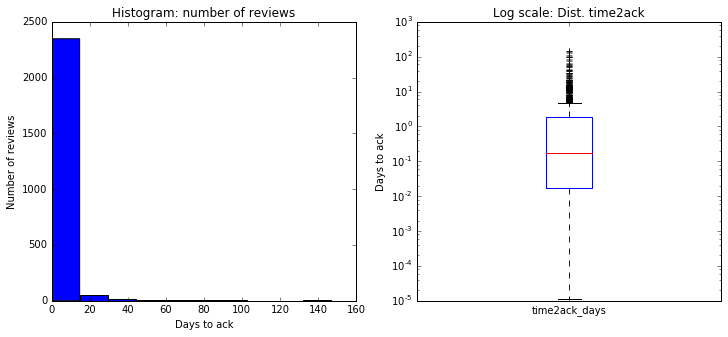

In [33]:
time2ack_list = list(time2ack)
time2ack_df = DataFrame(time2ack_list, columns=["subject", "date", "flag", "ack_time", "time2ack"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2ack_df["time2ack_days"] = (time2ack_df["time2ack"]/3600)/24


hist_chart = time2ack_df["time2ack_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2ack_df["time2ack_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to ack")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to ack")
boxplot_chart.set_title("Log scale: Dist. time2ack")

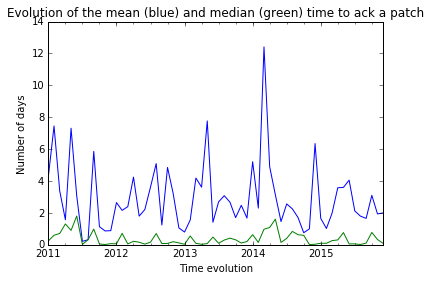

In [34]:
mean_time2ack = time2ack_df.set_index("ack_time").resample('M', how={"time2ack_days":np.mean})
median_time2ack = time2ack_df.set_index("ack_time").resample('M', how={"time2ack_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
time2ackTS = Series(mean_time2ack["time2ack_days"], index=dates)
time2ack_medianTS = Series(median_time2ack["time2ack_days"], index=dates)

time2ackTS_chart = time2ackTS.plot()
time2ack_medianTS.plot()
time2ackTS_chart.set_xlabel("Time evolution")
time2ackTS_chart.set_ylabel("Number of days")
time2ackTS_chart.set_title("Evolution of the mean (blue) and median (green) time to ack a patch")

In [35]:
#dates

# 3) BACKLOG ANALYSIS

Metrics to retrieve:
* Review (of series/patch) completed: all of the patch series merged
* Review (of series/patch) active: patches that were recently reviewed, we'll take the last 7 days as a potential timeframe.
* Review (of series/patch) stalled: patches older than 1 year
* Review (of series/patch) ongoing: patches younger than 1 year. This would include the active reviews.


## Reviews completed

In [36]:
# List of the most recent and completed reviews up to the date of this analysis
query = """ SELECT distinct ps.id as patch_serie, 
                   ps.subject, 
                   MAX(c.committer_date_utc) as merge_time
            FROM patch_series ps,
                 patch_series_version psv,
                 patches p,
                 commits c
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND p.commit_id = c.id 
            GROUP BY ps.id 
            ORDER BY merge_time desc """
completed_reviews_list = execute_query(cursor, query)

In [37]:
completed_reviews = list(completed_reviews_list)
completed_reviews_df = DataFrame(completed_reviews, columns=["patch_serie", "subject", "merge_time"])
completed_reviews_df

patch_serie                                            subject  \
0           10044         x86: xstate CPUID guest output adjustments   
1            9819      Test booting hvm guest with empty cdrom drive   
2           10025  make-flight: don't create ovmf tests for seabi...   
3           10048  xen/arm: warn the user that we cannot route SP...   
4           10020  xen/arm: arm64: Widen register access to mpidr...   
5           10021  xen/arm: Change the variable type of cpu_logic...   
6           10022  xen/arm: Make AFFINITY_MASK generate correct m...   
7           10023  xen:arm: arm64: Add correct MPIDR_HWID_MASK va...   
8           10024  xen/arm: arm64: Remove MPIDR multiprocessing e...   
9           10040  x86/mce: handle reserved domain ID in XEN_MC_m...   
10          10038                     Config.mk: update qemu-xen tag   
11           9992                     Config.mk: update qemu-xen tag   
12           9998  xen: sched: avoid races on time values  read f...   
13           9991  x86emul: suppress writeback upon unsuccessful ...   
14           9980  xen/nested_p2m: Don't walk EPT tables with a r...   
15           9965          x86/PoD: skip eager reclaim when possible   
16           9936  IOMMU/x86: per-domain control structure is not...   
17           9682  x86: accommodate 32-bit PV guests with  SMEP/S...   
18           9666  x86: accommodate 32-bit PV guests with  SMAP/S...   
19           9088  x86/P2M: consolidate handling of types not  re...   
20          10019        x86/compat: correct SMEP/SMAP NOPs patching   
21          10029                   x86/psr: make opt_psr persistent   
22          10011  docs: update xl manpage about {block, network}...   
23          10026                  xl: use xstrdup in cpurange_parse   
24          10018  xen: RTDS: fix another instance of the 'read N...   
25          10015  libxl: drop stray const from function return type   
26           9994                tools: bump library version numbers   
27          10016  libxl: Avoid advertising about device_model_us...   
28           8803             Config.mk: Non-debug build by default.   
29           9999  docs/build: Avoid using multi-target pattern r...   
...           ...                                                ...   
5173           76               MCE:  Handle the vMCA bank correctly   
5174           70  xend: destroy restored domain when its device ...   
5175           71                     pygrub: improve grub 2 support   
5176           57               VT-d: improve RMRR validity checking   
5177           67                 Get libconfig tarball from xenbits   
5178           68  x86: check if desc->action is NULL when unbind...   
5179           69                       blktap: fix blktapctrl abort   
5180           65                    libxc: mmapbatch-v2 adjustments   
5181           62                      x86: kill msix_flush_writes()   
5182           61                        x86: dump full IRQ affinity   
5183           60              x86: add keyhandler to dump MSI state   
5184           55                        tools: fix sysfs error path   
5185           63              xentrace: XC_PAGE_SIZE should be used   
5186           56      VT-d: handle return value of deassign_device    
5187           51        xc_domain_save: allocate pfn_err before use   
5188           49                        libxl: fix "xl list" output   
5189           45        Change default cpufreq governor to ondemand   
5190           41  xend: NUMA: fix division by zero on unpopulate...   
5191           39                 libxl: add a newline to xl logging   
5192           35           x86: fix unmaskable msi assignment issue   
5193           33             x86: minor cleanup to arch_memory_op()   
5194           30      libxc: use new (replacement) mmap-batch ioctl   
5195           31       qemu: use new (replacement) mmap-batch ioctl   
5196           26               [TOOLS] blktap

In [38]:
# Total number of completed reviews up to the date of this analysis
query = """ SELECT count(distinct(ps.id)) as merged_patch_series
            FROM patch_series ps,
                 patch_series_version psv,
                 patches p,
                 commits c
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND p.commit_id = c.id 
            """
total_completed_reviews = execute_query(cursor, query)

In [39]:
total_completed_reviews

((5203L,),)

## Reviews active

In [40]:
# List of recent reviewed patch series but not merged.
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date_utc) as last_reviewed_date
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc BETWEEN DATE_SUB(NOW(), INTERVAL 60 DAY) AND NOW() 
            GROUP BY ps.id
            ORDER BY f.date_utc desc """ # INITIAL VALUE OF 60 DAYS
recent_reviews = execute_query(cursor, query)

In [41]:
recent_reviews_list = list(recent_reviews)
recent_reviews_df = DataFrame(recent_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
recent_reviews_df

Empty DataFrame
Columns: [patch_serie, subject, last_reviewed_date]
Index: []

In [42]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc BETWEEN DATE_SUB(NOW(), INTERVAL 60 DAY) AND NOW()  """ # INITIAL VALUE OF 60 DAYS
total_recent_reviews = execute_query(cursor, query)

In [43]:
total_recent_reviews

((0L,),)

## Reviews ongoing

In [44]:
# List of last year reviewed patch series but not merged (and not recent reviewed)
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date_utc) as last_reviewed_date
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc BETWEEN DATE_SUB(NOW(), INTERVAL 365 DAY) AND DATE_SUB(NOW(), INTERVAL 60 DAY)
            GROUP BY ps.id
            ORDER BY f.date_utc desc """ # INITIAL VALUE OF 60 DAYS
last_year_reviews = execute_query(cursor, query)

In [45]:
last_year_reviews_list = list(last_year_reviews)
last_year_reviews_df = DataFrame(last_year_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
last_year_reviews_df

patch_serie                                            subject  \
0          10044         x86: xstate CPUID guest output adjustments   
1          10048  xen/arm: warn the user that we cannot route SP...   
2          10046       x86/cpuid: fix dom0 crash on skylake machine   
3          10035                           xen/arm: setup: fix typo   
4          10040  x86/mce: handle reserved domain ID in XEN_MC_m...   
5          10029                   x86/psr: make opt_psr persistent   
6           9981  AMD IOMMU: Introduce support for IVHD block ty...   
7          10020  xen/arm: arm64: Widen register access to mpidr...   
8          10019        x86/compat: correct SMEP/SMAP NOPs patching   
9          10022  xen/arm: Make AFFINITY_MASK generate correct m...   
10         10026                  xl: use xstrdup in cpurange_parse   
11         10018  xen: RTDS: fix another instance of the 'read N...   
12         10013                              xen: use vma_pages().   
13         10017                             xen: Clean up includes   
14         10012  xen/arm: Introduce alternative runtime patchin...   
15          9979  Fix xen crash when starting HVM guest due to m...   
16          9999  docs/build: Avoid using multi-target pattern r...   
17         10003  Support consistent reads of mapped vcpu_runsta...   
18          9993                xen: add steal_clock support on x86   
19         10001  xen/arm: smpboot: drop unneeded code in start_...   
20          9998  xen: sched: avoid races on time values  read f...   
21          9991  x86emul: suppress writeback upon unsuccessful ...   
22          9983                     xen: sched: rtds refactor code   
23          9989  x86: make SMEP/SMAP suppression tolerate  NMI/...   
24          9988             x86: refine debugging of SMEP/SMAP fix   
25          9985  xen/device-tree: Do not remap IRQs for seconda...   
26          9986  x86/cpuid: Avoid unconditionally clobbering IT...   
27          9980  xen/nested_p2m: Don't walk EPT tables with a r...   
28          9975          xen: remove incorrect forward declaration   
29          9984  x86/compat: Cleanup and further debugging of S...   
..           ...                                                ...   
369         9099          efi: Fix booting failure with UEFI on ARM   
370         9093  tools/ocaml/xb: Correct calculations of data/s...   
371         9088  x86/P2M: consolidate handling of types not  re...   
372         9089        perfc: count number of explicit vcpu yields   
373         9001  smpboot: Add smpboot state variables instead o...   
374         8527          Introduce HVM without dm and new boot ABI   
375         8813           libxc: support building large pv-domains   
376         9082  x86/hvm: make sure stdvga cache cannot be re-e...   
377         9057  blkif.h: document blkif multi-queue/ring exten...   
378         5348  xen/arm/arm64: CONFIG_PARAVIRT and  stolen tic...   
379         9072                      Futher cpuid handling cleanup   
380         8729                 Add VT-d Posted-Interrupts support   
381         9066                          Futher work after XSA-150   
382         9063  cpufreq: allow ordinary boolean options to be ...   
383         9064    x86/HAP: use %pv printk() format where suitable   
384         9062  x86: make compat_iret() domain crash cases  di...   
385         9060  timer-op: demote a debugging message to really...   
386         9059  x86/PoD: tighten conditions for checking super...   
387         8966  xen: sched: fix locking of {insert, remove}_vc...   
388         9023  xl: log an error if libxl_cpupool_destroy() fails   
389         9044  x86/xen: add reschedule point when mapping for...   
390         9035                 disambiguate symbol names (part 2)   
391         7957            iommu: add rmrr Xen command line option   
392         9046  xen: fix the check of e_pfn in xen_find_pfn_range   
393         9050  xl: improve

In [46]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc BETWEEN DATE_SUB(NOW(), INTERVAL 365 DAY) AND DATE_SUB(NOW(), INTERVAL 60 DAY)  """ # INITIAL VALUE OF 60 DAYS
total_last_year_reviews = execute_query(cursor, query)

In [47]:
total_last_year_reviews

((399L,),)

## Reviews stalled

In [48]:
# Stalled list of reviews: those with review activity and older than one year
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date_utc) as last_reviewed_date
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc < DATE_SUB(NOW(), INTERVAL 365 DAY)
            GROUP BY ps.id
            ORDER BY f.date_utc desc """ 
stalled_reviews = execute_query(cursor, query)

In [49]:
stalled_reviews_list = list(stalled_reviews)
stalled_reviews_df = DataFrame(stalled_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
stalled_reviews_df

patch_serie                                            subject  \
0            9023  xl: log an error if libxl_cpupool_destroy() fails   
1            9017    OvmfPkg: XenPvBlkDxe: handle empty cdrom drives   
2            9014                          disambiguate symbol names   
3            8879  x86/HVM: correct page dirty marking in  hvm_ma...   
4            9009  use clear_domain_page() instead of open coding it   
5            9015  Deter enabling of EPT A/D bit plus coding styl...   
6            8979                raisin: enable ovmf build for arm64   
7            8998    xen-netfront: update num_queues to real created   
8            9007                        xen,arm: enable cpu_hotplug   
9            8991             x86: capabilities handling adjustments   
10           8985  libxc: create an initial FPU state for HVM guests   
11           8983                                  x86/NUMA: cleanup   
12           8982  x86/NUMA: fix SRAT table processor entry  pars...   
13           8981  x86/time: slightly streamline  __update_vcpu_s...   
14           8980                   x86: hide MWAITX from PV domains   
15           8968     libxc: remove superpages option for pv domains   
16           8966  xen: sched: fix locking of {insert, remove}_vc...   
17           8959                       x86/p2m: fix typo "populete"   
18           8957             tools/python: remove broken xl binding   
19           8949      build: drop unused config variable CONFIG_HVM   
20           8947  xen/arm: psci: use SMC64 function ID when avai...   
21           8946  flask: Allow initial domain to use XENPF_get_s...   
22           8940            Various fixes - libelf, paging, blktap.   
23           8934          use mask operations instead of test_bit()   
24           8933  x86/p2m-pt: tighten conditions of IOMMU  mappi...   
25           8926  xen: sched: improve (a lot! :-D) Credit2  runq...   
26           8928         xen: Introduce VM_EVENT_FLAG_SET_REGISTERS   
27           8908  x86/PoD: shorten certain operations on  higher...   
28           8911  x86/EPT: defer enabling of A/D maintenance  un...   
29           8919                      VT-d: x2APIC + IR adjustments   
...           ...                                                ...   
1051         3637           qemu-xen-traditional: xen_disk backports   
1052         3603  xen_disk: implement BLKIF_OP_FLUSH_DISKCACHE, ...   
1053         2842                                Xen PCI Passthrough   
1054         3163                                save/restore on Xen   
1055         3208             prevent Qemu from waking up needlessly   
1056         3151                            initial suspend support   
1057         2847  xen: map foreign pages for shared rings by upd...   
1058         2781  xenbus: Fix loopback event channel assuming do...   
1059         2670  Prevent host crash after executing in dom0 'rm...   
1060         2539              Collected vdso/vsyscall fixes for 3.1   
1061         2436                       Modpost section mismatch fix   
1062         2397  qemu_ram_ptr_length: take ram_addr_t as arguments   
1063         2404                    Linux: 6 arguments hypercall v3   
1064         2338     x86: remove x86_init.mapping.pagetable_reserve   
1065         2069  mm: Extend memory hotplug API to allow memory ...   
1066         2068  mm: Add SECTION_ALIGN_UP() and SECTION_ALIGN_D...   
1067         2244                  nestedsvm: fix fpu context switch   
1068         2193  Two patches fixing regression introduced by 'x...   
1069         2179  pv-grub: Fix for incorrect dom->p2m_host[] lis...   
1070         2067      mm: Optimize pfn calculation in online_page()   
1071         1768                         xen network backend driver   
1072         1887                   Xen PCI fronted fixes for 2.6.39   
1073         1878  xen: suspend and resume system devices when ru...   
1074         1815  Consider E820 non-RAM and E

In [50]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM patch_series ps, 
                 patch_series_version psv, 
                 patches p, 
                 flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM patch_series ps,
                        patch_series_version psv,
                        patches p,
                        commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date_utc < DATE_SUB(NOW(), INTERVAL 365 DAY)"""
total_stalled_reviews = execute_query(cursor, query)

In [51]:
int(total_stalled_reviews[0][0])

1081

# 4) PATCH SERIES COMPLEXITY ANALYSIS

Metrics to retrieve:
* Number of versions per patch serie
* From patches merged: check number of 'touched' files plus added and removed lines
* Comments received per patch
* Number of patches per patch serie

## Number of versions per patch serie

In [52]:
query = """ SELECT ps_id as patch_serie,
                   COUNT(DISTINCT(version)) as versions,
                   MIN(date_utc) as patch_serie_first_date
            FROM patch_series_version
            GROUP BY ps_id """
iterations = execute_query(cursor, query)

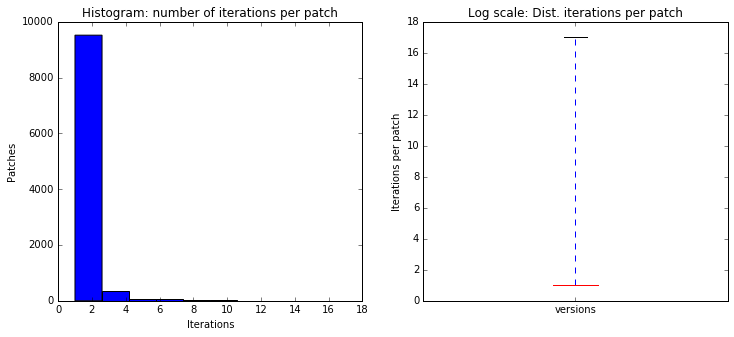

In [53]:
iterations_list = list(iterations)
iterations_df = DataFrame(iterations_list, columns=["patch_serie", "versions", "patch_serie_first_date"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = iterations_df["versions"].plot(kind="hist", ax=axs[0])
boxplot_chart = iterations_df["versions"].plot(kind="box", ax=axs[1])

#chart labels
hist_chart.set_xlabel("Iterations")
hist_chart.set_ylabel("Patches")
hist_chart.set_title("Histogram: number of iterations per patch")

boxplot_chart.set_ylabel("Iterations per patch")
boxplot_chart.set_title("Log scale: Dist. iterations per patch")

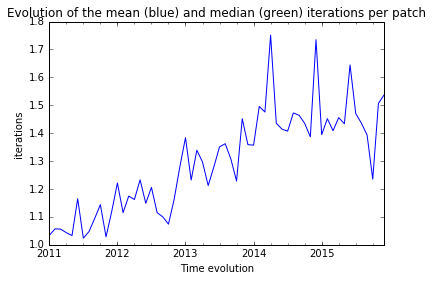

In [54]:
mean_iterations = iterations_df.set_index("patch_serie_first_date").resample('M', how={"versions":np.mean})
median_iterations = iterations_df.set_index("patch_serie_first_date").resample('M', how={"versions":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
iterationsTS = Series(mean_iterations["versions"], index=dates)
iterations_medianTS = Series(median_iterations["versions"], index=dates)

iterations_chart = iterationsTS.plot()
iterations_medianTS.plot()
iterations_chart.set_xlabel("Time evolution")
iterations_chart.set_ylabel("iterations")
iterations_chart.set_title("Evolution of the mean (blue) and median (green) iterations per patch")

## Number of 'touched' files, added and removed lines

In [55]:
query = """ SELECT psv.ps_id as patch_serie,
                   max(c.committer_date_utc) as merge_time, 
                   COUNT(DISTINCT(a.file_id)) as touched_files,
                   SUM(cl.added) as added_lines,
                   SUM(cl.removed) as removed_lines
            FROM patch_series_version psv, 
                 patches p, 
                 commits c, 
                 xen_reports_cvsanaly.scmlog s, 
                 xen_reports_cvsanaly.actions a, 
                 xen_reports_cvsanaly.commits_lines cl 
            WHERE psv.id = p.ps_version_id AND 
                  p.commit_id = c.id AND 
                  c.rev=s.rev AND 
                  s.id=a.commit_id AND 
                  s.id=cl.commit_id 
            GROUP BY psv.ps_id """
modified_code = execute_query(cursor, query)

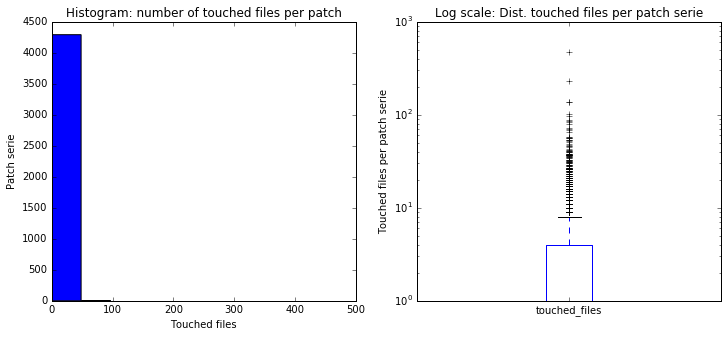

In [56]:
modified_code_list = list(modified_code)
modified_code_df = DataFrame(modified_code_list, columns=["patch_serie", "merge_time", "touched_files", "added_lines", "removed_lines"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = modified_code_df["touched_files"].plot(kind="hist", ax=axs[0])
boxplot_chart = modified_code_df["touched_files"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Touched files")
hist_chart.set_ylabel("Patch serie")
hist_chart.set_title("Histogram: number of touched files per patch")

boxplot_chart.set_ylabel("Touched files per patch serie")
boxplot_chart.set_title("Log scale: Dist. touched files per patch serie")

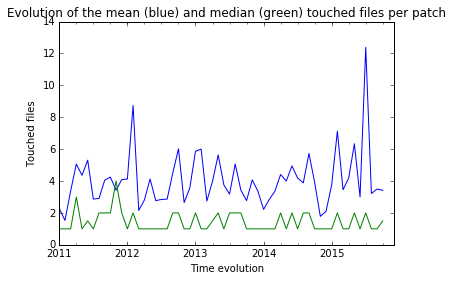

In [57]:
# Touched files per patch serie in mean. This is also time series distributed to check if there are more touched files per patch series in mean and median
mean_modified_code = modified_code_df.set_index("merge_time").resample('M', how={"touched_files":np.mean})
median_modified_code = modified_code_df.set_index("merge_time").resample('M', how={"touched_files":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
modified_codeTS = Series(mean_modified_code["touched_files"], index=dates)
modified_code_medianTS = Series(median_modified_code["touched_files"], index=dates)

modified_code_chart = modified_codeTS.plot()
modified_code_medianTS.plot()
modified_code_chart.set_xlabel("Time evolution")
modified_code_chart.set_ylabel("Touched files")
modified_code_chart.set_title("Evolution of the mean (blue) and median (green) touched files per patch")

## Comments received per patch serie

In [58]:
# Let's calculate evolution of comments in general when they were sent
# We should ignore 1970 emails with wrong sent date
query = """ SELECT MIN(psv.date_utc) as patch_serie_first_date,
                   ps_id as patch_serie,
                   count(distinct(c.id)) as comments
            FROM patch_series_version psv,
                 patches p,
                 comments c 
            WHERE psv.id = p.ps_version_id and 
                  p.id = c.patch_id and
                  year(psv.date_utc) > 2004 and
                  year(psv.date_utc) < 2016
            GROUP BY ps_id;
           
        """
comments = execute_query(cursor, query)

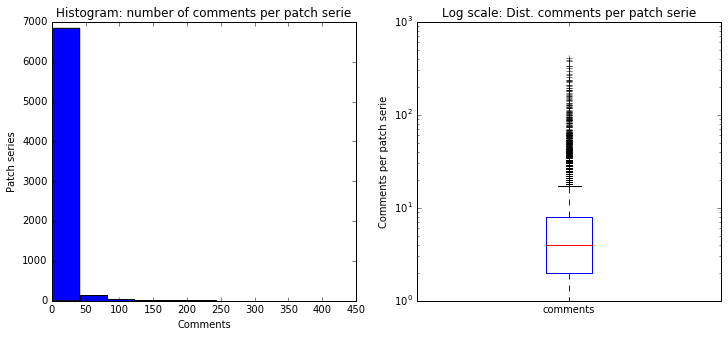

In [59]:
comments_list = list(comments)
comments_df = DataFrame(comments_list, columns=["patch_serie_first_date", "patch_serie", "comments"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = comments_df["comments"].plot(kind="hist", ax=axs[0])
boxplot_chart = comments_df["comments"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Comments")
hist_chart.set_ylabel("Patch series")
hist_chart.set_title("Histogram: number of comments per patch serie")

boxplot_chart.set_ylabel("Comments per patch serie")
boxplot_chart.set_title("Log scale: Dist. comments per patch serie")


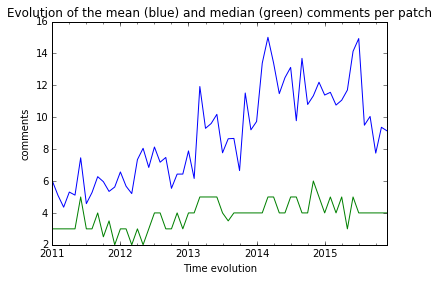

In [60]:
# Comments per patch serie in mean. This is also time series distributed to check if there are more comments per patch series in mean and median
mean_comments = comments_df.set_index("patch_serie_first_date").resample('M', how={"comments":np.mean})
median_comments = comments_df.set_index("patch_serie_first_date").resample('M', how={"comments":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
commentsTS = Series(mean_comments["comments"], index=dates)
comments_medianTS = Series(median_comments["comments"], index=dates)

comments_chart = commentsTS.plot()
comments_medianTS.plot()
comments_chart.set_xlabel("Time evolution")
comments_chart.set_ylabel("comments")
comments_chart.set_title("Evolution of the mean (blue) and median (green) comments per patch")

## Number of patches per patch serie

In [61]:
query = """ SELECT  distinct psv.ps_id as patch_serie,  
                   psv.date_utc as first_send, 
                   max(t.patches) as numpatches 
             FROM patch_series_version psv, 
                  patches p, 
                     (SELECT psv.ps_id, 
                             p.ps_version_id, 
                             count(distinct(p.id)) as patches 
                      FROM patch_series_version psv, 
                           patches p 
                      WHERE psv.id = p.ps_version_id  
                      GROUP BY psv.ps_id, 
                               p.ps_version_id) t 
              WHERE psv.ps_id = t.ps_id AND 
                    p.ps_version_id=t.ps_version_id AND 
                    psv.id = p.ps_version_id 
              GROUP BY psv.ps_id
          """
patches_ps = execute_query(cursor, query)

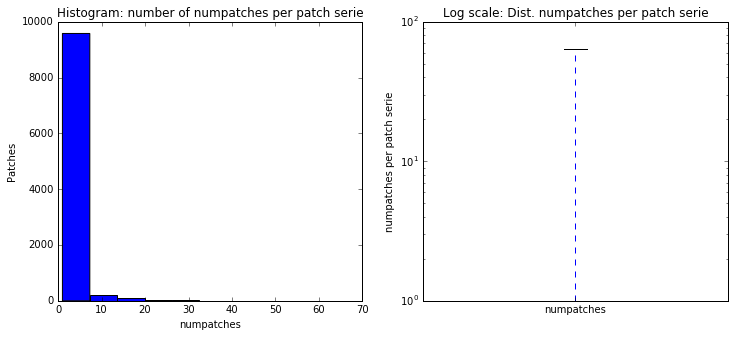

In [62]:
numpatches_list = list(patches_ps)
numpatches_df = DataFrame(numpatches_list, columns=["patch_serie", "first_send", "numpatches"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = numpatches_df["numpatches"].plot(kind="hist", ax=axs[0])
boxplot_chart = numpatches_df["numpatches"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("numpatches")
hist_chart.set_ylabel("Patches")
hist_chart.set_title("Histogram: number of numpatches per patch serie")

boxplot_chart.set_ylabel("numpatches per patch serie")
boxplot_chart.set_title("Log scale: Dist. numpatches per patch serie")


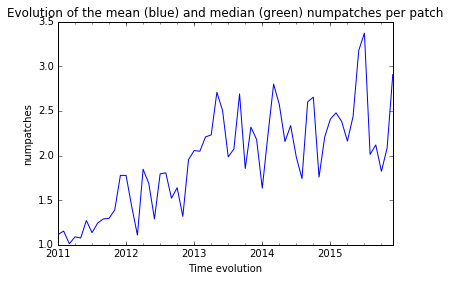

In [63]:
# numpatches per patch serie in mean. This is also time series distributed to check if there are more numpatches per patch series in mean and median
mean_numpatches = numpatches_df.set_index("first_send").resample('M', how={"numpatches":np.mean})
median_numpatches = numpatches_df.set_index("first_send").resample('M', how={"numpatches":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
numpatchesTS = Series(mean_numpatches["numpatches"], index=dates)
numpatches_medianTS = Series(median_numpatches["numpatches"], index=dates)

numpatches_chart = numpatchesTS.plot()
numpatches_medianTS.plot()
numpatches_chart.set_xlabel("Time evolution")
numpatches_chart.set_ylabel("numpatches")
numpatches_chart.set_title("Evolution of the mean (blue) and median (green) numpatches per patch")

# 5) PATCH SERIES COMMUNITY

Metrics to retrieve:
* Top people sending patches
* Top people reviewing patches
* For all of those, basic analysis with organization info based on email domain


## Top people sending patches (with affiliation if possible)

In [64]:
#TODO

## Top people reviewing patches (with affiliation if possible)

In [65]:
#TODO

# 6) ANALYSIS

## Splitting by date

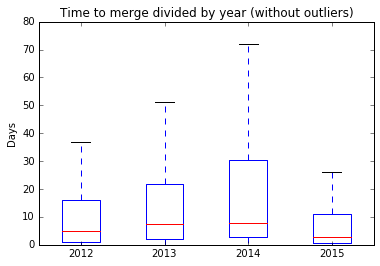

In [68]:
# Taking time2merge dataframe
time2merge_2015 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-01-01']
time2merge_2015 = time2merge_df[time2merge_df["first_patch_date"] >= '2016-01-01']

time2merge_2014 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-01-01']
time2merge_2014 = time2merge_2014[time2merge_2014["first_patch_date"] < '2015-01-01']

time2merge_2013 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013 = time2merge_2013[time2merge_2013["first_patch_date"] < '2014-01-01']

time2merge_2012 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-01-01']
time2merge_2012 = time2merge_2012[time2merge_2012["first_patch_date"] < '2013-01-01']


data=[time2merge_2012["time2merge_days"], time2merge_2013["time2merge_days"], time2merge_2014["time2merge_days"], time2merge_2015["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4], ['2012', '2013', '2014', '2015'])
pylab.title("Time to merge divided by year (without outliers)")
pylab.ylabel("Days")

### Splitting by semester and taking the time when the changeset was open

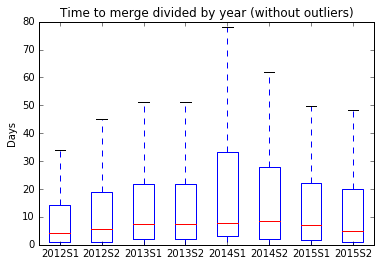

In [69]:
# Taking time2merge dataframe
time2merge_2015_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-07-01']
time2merge_2015_s2 = time2merge_2015_s2[time2merge_2015_s2["first_patch_date"] < '2016-01-01']
time2merge_2015_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-01-01']
time2merge_2015_s1 = time2merge_2015_s1[time2merge_2015_s1["first_patch_date"] < '2015-07-01']

time2merge_2014_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-07-01']
time2merge_2014_s2 = time2merge_2014_s2[time2merge_2014_s2["first_patch_date"] < '2015-01-01']
time2merge_2014_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-01-01']
time2merge_2014_s1 = time2merge_2014_s1[time2merge_2014_s1["first_patch_date"] < '2014-07-01']

time2merge_2013_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013_s2 = time2merge_2013_s2[time2merge_2013_s2["first_patch_date"] < '2014-01-01']
time2merge_2013_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013_s1 = time2merge_2013_s1[time2merge_2013_s1["first_patch_date"] < '2014-01-01']

time2merge_2012_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-07-01']
time2merge_2012_s2 = time2merge_2012_s2[time2merge_2012_s2["first_patch_date"] < '2013-01-01']
time2merge_2012_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-01-01']
time2merge_2012_s1 = time2merge_2012_s1[time2merge_2012_s1["first_patch_date"] < '2012-07-01']


data=[time2merge_2012_s1["time2merge_days"], time2merge_2012_s2["time2merge_days"], time2merge_2013_s1["time2merge_days"], time2merge_2013_s2["time2merge_days"], time2merge_2014_s1["time2merge_days"], time2merge_2014_s2["time2merge_days"], time2merge_2015_s1["time2merge_days"], time2merge_2015_s2["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
pylab.title("Time to merge divided by year (without outliers)")
pylab.ylabel("Days")

### Splitting by semester and taking the time when the changeset was merged

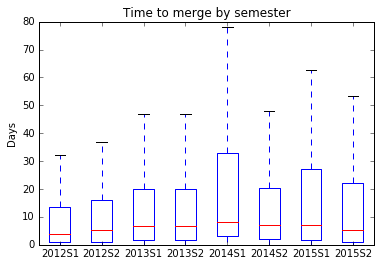

In [71]:
# Taking time2merge dataframe
time2merge_2015_s2 = time2merge_df[time2merge_df["merge_time"] >= '2015-07-01']
time2merge_2015_s2 = time2merge_2015_s2[time2merge_2015_s2["merge_time"] < '2016-01-01']
time2merge_2015_s1 = time2merge_df[time2merge_df["merge_time"] >= '2015-01-01']
time2merge_2015_s1 = time2merge_2015_s1[time2merge_2015_s1["merge_time"] < '2015-07-01']

time2merge_2014_s2 = time2merge_df[time2merge_df["merge_time"] >= '2014-07-01']
time2merge_2014_s2 = time2merge_2014_s2[time2merge_2014_s2["merge_time"] < '2015-01-01']
time2merge_2014_s1 = time2merge_df[time2merge_df["merge_time"] >= '2014-01-01']
time2merge_2014_s1 = time2merge_2014_s1[time2merge_2014_s1["merge_time"] < '2014-07-01']

time2merge_2013_s2 = time2merge_df[time2merge_df["merge_time"] >= '2013-01-01']
time2merge_2013_s2 = time2merge_2013_s2[time2merge_2013_s2["merge_time"] < '2014-01-01']
time2merge_2013_s1 = time2merge_df[time2merge_df["merge_time"] >= '2013-01-01']
time2merge_2013_s1 = time2merge_2013_s1[time2merge_2013_s1["merge_time"] < '2014-01-01']

time2merge_2012_s2 = time2merge_df[time2merge_df["merge_time"] >= '2012-07-01']
time2merge_2012_s2 = time2merge_2012_s2[time2merge_2012_s2["merge_time"] < '2013-01-01']
time2merge_2012_s1 = time2merge_df[time2merge_df["merge_time"] >= '2012-01-01']
time2merge_2012_s1 = time2merge_2012_s1[time2merge_2012_s1["merge_time"] < '2012-07-01']


data=[time2merge_2012_s1["time2merge_days"], time2merge_2012_s2["time2merge_days"], time2merge_2013_s1["time2merge_days"], time2merge_2013_s2["time2merge_days"], time2merge_2014_s1["time2merge_days"], time2merge_2014_s2["time2merge_days"], time2merge_2015_s1["time2merge_days"], time2merge_2015_s2["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
pylab.title("Time to merge by semester")
pylab.ylabel("Days")

## Splitting by number of patches in the patch serie

In [72]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MIN(psv.date_utc), MAX(c.committer_date_utc)) as time2merge,
                   MIN(psv.date_utc) as first_patch_date, 
                   MAX(c.committer_date_utc) as merge_time,
                   MAX(t.patches) as numpatches 
             FROM patch_series_version psv, 
                  patches p, 
                     (SELECT psv.ps_id, 
                             p.ps_version_id, 
                             count(*) as patches 
                      FROM patch_series_version psv, 
                           patches p 
                      WHERE psv.id = p.ps_version_id  
                      GROUP BY psv.ps_id, 
                               p.ps_version_id) t,
                   commits c
              WHERE psv.ps_id = t.ps_id AND 
                    p.ps_version_id=t.ps_version_id AND 
                    psv.id = p.ps_version_id AND
                    p.commit_id = c.id
              GROUP BY psv.ps_id 
              HAVING time2merge > 0 and time2merge < 1000*3600*24"""
time2merge_extra = execute_query(cursor, query)

In [73]:
time2merge_extra_list = list(time2merge_extra)
time2merge_extra_df = DataFrame(time2merge_extra_list, columns=["patch_serie", "time2merge", "first_patch_date", "merge_time", "numpatches"])
time2merge_extra_df["time2merge_days"] = (time2merge_extra_df["time2merge"]/3600)/24

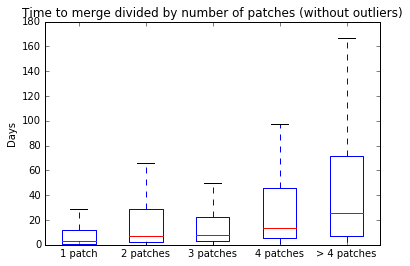

In [74]:
time2merge_extra_df_1patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==1]
time2merge_extra_df_2patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==2]
time2merge_extra_df_3patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==3]
time2merge_extra_df_4patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==4]
time2merge_extra_df_5patch = time2merge_extra_df[time2merge_extra_df["numpatches"]>4]

data=[time2merge_extra_df_1patch["time2merge_days"], time2merge_extra_df_2patch["time2merge_days"], time2merge_extra_df_3patch["time2merge_days"],
      time2merge_extra_df_4patch["time2merge_days"], time2merge_extra_df_5patch["time2merge_days"]]
figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5], ['1 patch', '2 patches', '3 patches', '4 patches', '> 4 patches'])
pylab.title("Time to merge divided by number of patches (without outliers)")
pylab.ylabel("Days")

### Splitting by number of patchsets in the patch series and by semester

In [75]:
def draw_boxplots(title, data_df, field):
    # Taking data dataframe
    data_2015_s2 = data_df[data_df[field] >= '2015-07-01']
    data_2015_s2 = data_2015_s2[data_2015_s2[field] < '2016-01-01']
    data_2015_s1 = data_df[data_df[field] >= '2015-01-01']
    data_2015_s1 = data_2015_s1[data_2015_s1[field] < '2015-07-01']

    data_2014_s2 = data_df[data_df[field] >= '2014-07-01']
    data_2014_s2 = data_2014_s2[data_2014_s2[field] < '2015-01-01']
    data_2014_s1 = data_df[data_df[field] >= '2014-01-01']
    data_2014_s1 = data_2014_s1[data_2014_s1[field] < '2014-07-01']

    data_2013_s2 = data_df[data_df[field] >= '2013-01-01']
    data_2013_s2 = data_2013_s2[data_2013_s2[field] < '2014-01-01']
    data_2013_s1 = data_df[data_df[field] >= '2013-01-01']
    data_2013_s1 = data_2013_s1[data_2013_s1[field] < '2014-01-01']

    data_2012_s2 = data_df[data_df[field] >= '2012-07-01']
    data_2012_s2 = data_2012_s2[data_2012_s2[field] < '2013-01-01']
    data_2012_s1 = data_df[data_df[field] >= '2012-01-01']
    data_2012_s1 = data_2012_s1[data_2012_s1[field] < '2012-07-01']


    data=[data_2012_s1["time2merge_days"], data_2012_s2["time2merge_days"], data_2013_s1["time2merge_days"], data_2013_s2["time2merge_days"], 
          data_2014_s1["time2merge_days"], data_2014_s2["time2merge_days"], data_2015_s1["time2merge_days"], data_2015_s2["time2merge_days"]]

    figure = pylab.boxplot(data, sym="")
    ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
    pylab.title("Time to merge by semester for" + title)
    pylab.ylabel("Days")
    


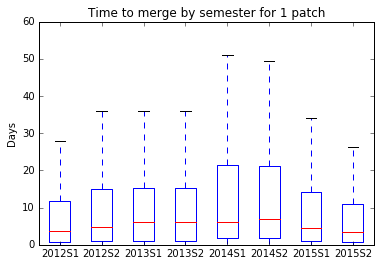

In [78]:
draw_boxplots(" 1 patch", time2merge_extra_df_1patch, "first_patch_date")


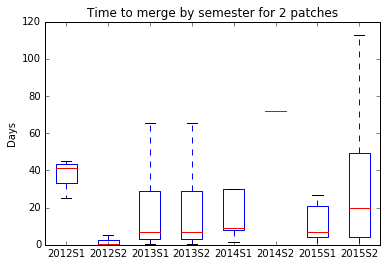

In [79]:
draw_boxplots(" 2 patches", time2merge_extra_df_2patch, "first_patch_date")



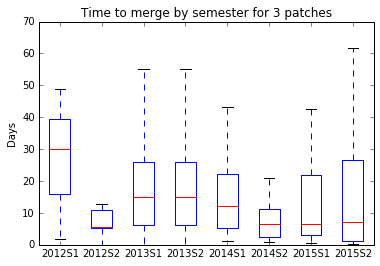

In [80]:
draw_boxplots(" 3 patches", time2merge_extra_df_3patch, "first_patch_date")


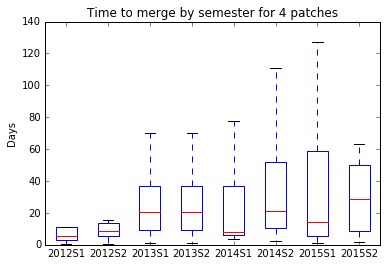

In [81]:
draw_boxplots(" 4 patches", time2merge_extra_df_4patch, "first_patch_date")


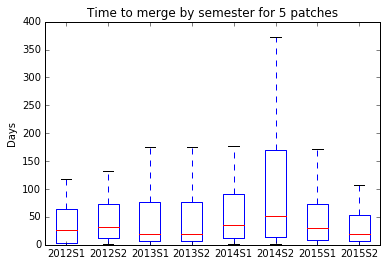

In [84]:
draw_boxplots(" 5 patches", time2merge_extra_df_5patch, "first_patch_date")

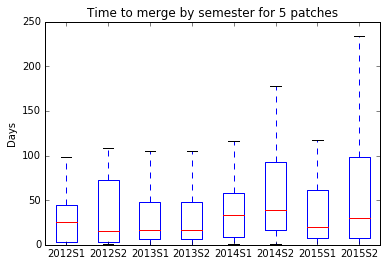

In [85]:
draw_boxplots(" 5 patches", time2merge_extra_df_5patch, "merge_time")

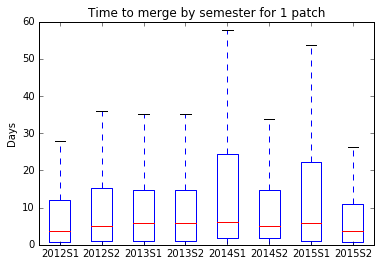

In [86]:
draw_boxplots(" 1 patch", time2merge_extra_df_1patch, "merge_time")

## Evolution of the number of patches per patch serie (so, are longer patch series taking place lately?)

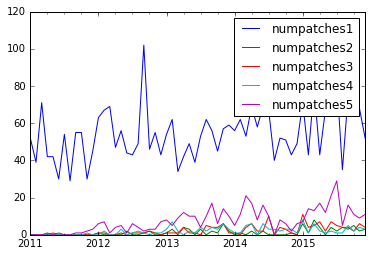

In [87]:
total_patch_series_1 = time2merge_extra_df_1patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_2 = time2merge_extra_df_2patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_3 = time2merge_extra_df_3patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_4 = time2merge_extra_df_4patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_5 = time2merge_extra_df_5patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})

#fig, ax = plt.subplots()
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2005-10 and ending in 2015-08

total_patch_series_1["numpatches1"] = total_patch_series_1["numpatches"]
total_patch_series_2["numpatches2"] = total_patch_series_2["numpatches"]
total_patch_series_3["numpatches3"] = total_patch_series_3["numpatches"]
total_patch_series_4["numpatches4"] = total_patch_series_4["numpatches"]
total_patch_series_5["numpatches5"] = total_patch_series_5["numpatches"]

patches1TS = Series(total_patch_series_1["numpatches1"], index=dates)
patches2TS = Series(total_patch_series_2["numpatches2"], index=dates)
patches3TS = Series(total_patch_series_3["numpatches3"], index=dates)
patches4TS = Series(total_patch_series_4["numpatches4"], index=dates)
patches5TS = Series(total_patch_series_5["numpatches5"], index=dates)

patches_chart = patches1TS.plot()
patches2TS.plot()
patches3TS.plot()
patches4TS.plot()
patches5TS.plot()
patches_chart.legend()

## Relationship between the median time to merge and the existence of patch series bigger than 4 patches

In [88]:
patches5TS.corr(time2merge_medianTS)

0.13463182725988068

## Coverage analysis

In [89]:
#unique patches
query = """select year(p.date_utc),
                  count(distinct(p.id)) 
           from patches p,
                patch_series_version psv 
           where psv.version=1 and 
                 psv.id=p.ps_version_id 
           group by year(p.date_utc) """
unique_patches = execute_query(cursor, query)
unique_patches

((2010L, 1942L),
 (2011L, 1559L),
 (2012L, 1907L),
 (2013L, 2372L),
 (2014L, 2092L),
 (2015L, 2773L),
 (2016L, 929L))

In [90]:
#Unique patches matched to commits
query = """ select year(date_utc),
                   count(distinct(commit_id)) 
            from patches 
            group by year(date_utc) """
matched_commits = execute_query(cursor, query)
matched_commits

((2010L, 587L),
 (2011L, 615L),
 (2012L, 1108L),
 (2013L, 1549L),
 (2014L, 1558L),
 (2015L, 2114L),
 (2016L, 758L))